In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi': 1000})
import cython
%load_ext cython

In [ ]:
%%cython --compile-args=/Qvec-report:2 --compile-args=/O2 --compile-args=/fp:fast --compile-args=/arch:AVX2 --compile-args=/Qpar --compile-args=/GL --compile-args=/Ob2
# cython: boundscheck=False
# cython: wraparound=False
# cython: initializedcheck=False
# cython: exceptvalcheck=False
# cython: cdivision=True
# cython: nonecheck=False
# cython: overflowcheck=False
# cython: embedsignature=False
# cython: cdivision_warnings=False
# cython: binding=False
# cython: infer_types=True
# compiler_directives={'fast_math': True}
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
import numpy as np
import cython
import time
import h5py
cimport numpy as np
cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport sqrtl, sqrt, sinh, asinh, atanh, exp, fabs, fma
from libc.stdio cimport printf
from libc.string cimport memcpy
from libc.time cimport time, clock_t, clock, CLOCKS_PER_SEC
from cython.parallel import prange, parallel

################### utils for fluid sim #######################################

# These are the imported AVX intrinsic functions used for the minmod derivative
cdef extern from "immintrin.h" nogil:
    # AVX data types
    ctypedef struct __m256d:
        pass
    # Load/store operations
    __m256d _mm256_loadu_pd(const double*) noexcept
    void _mm256_storeu_pd(double*, __m256d) noexcept
    # Arithmetic operations
    __m256d _mm256_sub_pd(__m256d, __m256d) noexcept
    __m256d _mm256_mul_pd(__m256d, __m256d) noexcept
    # Comparison operations
    __m256d _mm256_cmp_pd(__m256d, __m256d, int) noexcept
    __m256d _mm256_and_pd(__m256d, __m256d) noexcept
    __m256d _mm256_andnot_pd(__m256d, __m256d) noexcept
    __m256d _mm256_or_pd(__m256d, __m256d) noexcept
    # Min/max operations
    __m256d _mm256_min_pd(__m256d, __m256d) noexcept
    __m256d _mm256_max_pd(__m256d, __m256d) noexcept
    # Set operations
    __m256d _mm256_set1_pd(double) noexcept
    __m256d _mm256_setzero_pd() noexcept
    # Blend operations
    __m256d _mm256_blendv_pd(__m256d, __m256d, __m256d) noexcept

cdef inline void minmod_derv(double[::1] u, double[::1] deriv,
        double theta_term, double dr_term, Py_ssize_t sizem) noexcept nogil:
    """Compute the minmod slope-limited derivative of array u into deriv using AVX vectorization.
    Parameters:
    
    u : input 1D array of doubles
    deriv : output 1D array of doubles (same size as u)
    theta_term : scaling factor for the second difference. 0.5 / theta (dividing by theta to avoid multiplication for 1st and 3rd diffs)
    dr_term : scaling factor for the final derivative. theta / dr (theta acccounting for division in theta_term)
    sizem : size of the arrays - 1 (as the first and last points are not computed)

    Returns the computed minmod derivative in the deriv array.
    """
    cdef:
        Py_ssize_t i, idx
        double* u_ptr = &u[0]
        double* d_ptr = &deriv[0]
        # AVX vectors
        __m256d um_vec, uc_vec, up_vec
        __m256d d1_vec, d2_vec, d3_vec
        __m256d s1_vec, s2_vec
        __m256d mask1_vec, mask2_vec, mask_zero_vec, mask_pos_vec, mask_neg_vec
        __m256d temp1_vec, temp2_vec, result_vec
        __m256d zero_vec = _mm256_setzero_pd()
        __m256d eps_vec = _mm256_set1_pd(1e-15)
        __m256d theta_vec = _mm256_set1_pd(theta_term)
        __m256d dr_vec = _mm256_set1_pd(dr_term)
        __m256d neg_eps_vec = _mm256_set1_pd(-1e-15)
        int vector_size = 4
        Py_ssize_t n_vectors = (sizem - 1) // vector_size
        double um, uc, up, d1, d2, d3, s1, s2, temp
        Py_ssize_t remaining_start = n_vectors * vector_size + 1
    i = 0
    while i < n_vectors * vector_size:
        idx = i + 1
        um_vec = _mm256_loadu_pd(&u_ptr[idx-1])      # u[i-1], u[i], u[i+1], u[i+2]
        uc_vec = _mm256_loadu_pd(&u_ptr[idx])        # u[i], u[i+1], u[i+2], u[i+3]
        up_vec = _mm256_loadu_pd(&u_ptr[idx+1])      # u[i+1], u[i+2], u[i+3], u[i+4]
        # Compute differences
        d1_vec = _mm256_sub_pd(uc_vec, um_vec)
        d2_vec = _mm256_mul_pd(_mm256_sub_pd(up_vec, um_vec), theta_vec)
        d3_vec = _mm256_sub_pd(up_vec, uc_vec)
        # Check if signs differ: (d1*d2 <= 0) or (d1*d3 <= 0)
        s1_vec = _mm256_mul_pd(d1_vec, d2_vec)
        s2_vec = _mm256_mul_pd(d1_vec, d3_vec)
        # mask_zero = (s1 <= 0) OR (s2 <= 0)
        mask1_vec = _mm256_cmp_pd(s1_vec, zero_vec, 2)  # _CMP_LE_OQ = 2
        mask2_vec = _mm256_cmp_pd(s2_vec, zero_vec, 2)
        mask_zero_vec = _mm256_or_pd(mask1_vec, mask2_vec)
        # Check sign of d1
        mask_pos_vec = _mm256_cmp_pd(d1_vec, eps_vec, 14)   # _CMP_GT_OQ = 14
        mask_neg_vec = _mm256_cmp_pd(d1_vec, neg_eps_vec, 1)  # _CMP_LT_OQ = 1
        # For positive d1: take min(d1, d2, d3)
        temp1_vec = _mm256_min_pd(d1_vec, d2_vec)
        temp1_vec = _mm256_min_pd(temp1_vec, d3_vec)
        # For negative d1: take max(d1, d2, d3)
        temp2_vec = _mm256_max_pd(d1_vec, d2_vec)
        temp2_vec = _mm256_max_pd(temp2_vec, d3_vec)
        # Select result based on sign of d1
        result_vec = _mm256_blendv_pd(zero_vec, temp1_vec, mask_pos_vec)
        result_vec = _mm256_blendv_pd(result_vec, temp2_vec, mask_neg_vec)
        # Apply zero mask if signs differ
        result_vec = _mm256_andnot_pd(mask_zero_vec, result_vec)
        # Apply scaling
        result_vec = _mm256_mul_pd(result_vec, dr_vec)
        # Store result
        _mm256_storeu_pd(&d_ptr[idx], result_vec)
        i += vector_size
    i = remaining_start
    # Handle remaining elements
    while i < sizem:
        um = u_ptr[i-1]
        uc = u_ptr[i]
        up = u_ptr[i+1]
        d1 = uc - um
        d2 = (up - um) * theta_term
        d3 = up - uc
        s1 = d1 * d2
        s2 = d1 * d3
        if (s1 <= 0.0) or (s2 <= 0.0):
            d_ptr[i] = 0.0
        elif d1 > 0.0:
            temp = d1 if d1 < d2 else d2
            d_ptr[i] = (temp if temp < d3 else d3) * dr_term
        elif d1 < 0.0:
            temp = d1 if d1 > d2 else d2
            d_ptr[i] = (temp if temp > d3 else d3) * dr_term
        else:
            d_ptr[i] = 0.0
        i += 1

cdef void initial(double* C, double gam, double gam2, double T_02, double delt, double del3, double lamb, double lam4, double a,
        double T_N, double T_C, double[:] r, double[:] Phi, double[:] E, double[:] k1_E, Py_ssize_t size) noexcept nogil:
    """Initialize the scalar field and energy density arrays based on the potential parameters. 
        The initial scalar field is approximated as an exponential bubble profile at r = 0, as given in https://arxiv.org/abs/1504.03291v2, eq (63).
    
    Parameters:
    C : pointer to double, output coefficient (- 1 / R)
    gam : double, parameter in the potential
    gam2 : double, parameter in the potential divided by 2
    T_02 : double, parameter in the potential squared
    delt : double, parameter in the potential
    del3 : double, parameter in the potential divided by 3
    lamb : double, parameter in the potential
    lam4 : double, parameter in the potential divided by 4
    a : double, parameter in the EoS divided by 3
    T_N : double, initial temperature
    T_C : double, critical temperature
    r : array of doubles, radial coordinates
    Phi : array of doubles, scalar field values
    E : array of doubles, energy density values
    k1_E : array of doubles, first RK4 step for energy density (used to carry potential derivative values into RHS function)
    size : Py_ssize_t, size of arrays

    Returns the initialized Phi, E and k1_E arrays, along with the coefficient C.

    """
    # 
    cdef double T2 = T_N * T_N
    cdef double T4 = T2 * T2
    cdef double Tdiff = T2 - T_02
    cdef double g_term = gam * Tdiff
    cdef double g_term2 = gam2 * Tdiff
    cdef double A = delt * T_N
    cdef double A1 = del3 * T_N
    cdef double A2 = A * A
    cdef double l = 2.0 * lamb
    cdef double ins = A2 - 2.0 * l * g_term
    cdef double root = sqrt(ins)
    # phi_b here is the minimiser of the potential at T = T_N, calculated by the quadratic formula (always the more positive root)
    # This is because the derivative of the 4-variable toy model can then be divided by phi to give a quadratic equation.
    cdef double phi_b = (A + root) / l
    cdef double pb2 = phi_b * phi_b
    cdef double mid = g_term2 - A1 * phi_b + lam4 * pb2
    # V is the minimum of the potential at T = T_N
    cdef double V = mid * pb2
    cdef double d3 = delt * delt * delt
    cdef double tc3 = T_C * T_C * T_C
    cdef double inv_l = 1.0 / (lamb * lamb * sqrt(lamb))
    # Surface tension sigma is given by eq. (15)
    cdef double sig = (2.0 * sqrt(2.0) / 81.0) * d3 * inv_l * tc3
    # - 1 / R coefficient for eq. (63) calculated from eq. (62)
    cdef double coeff = 0.25 * V / sig
    cdef int i
    cdef double r1, r2, term, ph, phi2, V_eff, vdp, dV_dT, e_init
    # Here the initial scalar field is set according to eq. (63). The initial energy density is equal to e (v = 0 at t = 0).
    # The derivative of the potential with respect to phi is also calculated and stored in k1_E for use in the RHS function during the first RK4 step.
    for i in prange(size, nogil=True, schedule = "dynamic"):
        r1 = r[i]
        r2 = r1 * r1
        term = r2 * coeff
        ph = phi_b * exp(term)
        Phi[i] = ph
        phi2 = ph * ph
        V_eff = g_term2 - A1 * ph + lam4 * phi2
        vdp = g_term - A * ph + lamb * phi2
        dV_dT = gam * T_N - del3 * ph
        e_init = 3.0 * a * T4 + V_eff * phi2 - T_N * dV_dT * phi2
        k1_E[i] = vdp * ph
        E[i] = e_init
    C[0] = coeff
    # Coefficient returned by pointer (so that it can be added to initial conditions in the h5 file saving if needed)

cdef inline void NewtonRaphson(double[::1] T_in, double[::1] v, double[::1] dVdP, double[::1] E, double[::1] Z, double[::1] Phi,
    double gam, double gam2, double delt, double del3, double lam4, double T_02, double a, Py_ssize_t size) noexcept nogil:
    """"Newton-Raphson solver to find the temperature given the energy & momentum density and scalar field values.
        The equation used is f(T) = (E + p(T) - w(T)) * (E + p(T)) + Z * Z = 0.
        The temperature is then used to calculate the fluid velocity and derivative of the potential with respect to phi.
    One step was found to be sufficient, which allows for efficient vectorization.

    Parameters:
    T_in : input/output 1D array of doubles, temperature values to be updated
    v : output 1D array of doubles, fluid velocity values
    dVdP : output 1D array of doubles, derivative of potential with respect to phi
    E : input 1D array of doubles, energy density values
    Z : input 1D array of doubles, momentum density values
    Phi : input 1D array of doubles, scalar field values
    gam : double, parameter in the potential
    gam2 : double, parameter in the potential divided by 2
    delt : double, parameter in the potential
    del3 : double, parameter in the potential divided by 3
    lam4 : double, parameter in the potential divided by 4
    T_02 : double, parameter in the potential squared
    a : double, parameter in the EoS divided by 3
    size : Py_ssize_t, size of arrays

    Returns the updated T_in, v and dVdP arrays.

    """
    cdef double phi, phi2, T, T1, T2, Tdiff, e, z, D_term, l_term, g1_term, V_eff, dV_dT, T3_term, T4_term
    cdef double Ep, w, dp, dw, z2, mid, f, temp, df, frac
    cdef double* Phi_ptr = &Phi[0]
    cdef double* E_ptr = &E[0]
    cdef double* Z_ptr = &Z[0]
    cdef double* T_ptr = &T_in[0]
    cdef double* v_ptr = &v[0]
    cdef double* dV_ptr = &dVdP[0]
    for i in prange(size, schedule = "dynamic"):
        T = T_ptr[i]
        phi = Phi_ptr[i]
        e = E_ptr[i]
        z = Z_ptr[i]
        phi2 = phi * phi
        D_term = phi * del3
        z2 = z * z
        l_term = lam4 * phi2
        T2 = T * T
        Tdiff = T2 - T_02
        V_eff = gam2 * Tdiff + l_term - D_term * T
        g_term = gam * T
        T1 = g_term - D_term
        dV_dT = T1 * phi2
        T3_term = T2 * T * a
        T4_term = T2 * T2 * a
        Ep = T4_term - V_eff * phi2 + e
        w = 4.0 * T4_term - T * dV_dT
        dp = 4.0 * T3_term - dV_dT
        dw = 16.0 * T3_term - g_term * phi2 - dV_dT
        mid = Ep - w
        f = mid * Ep - z2
        temp = 2.0 * dp - dw
        df = temp * Ep - w * dp
        frac = f / df
        T1 = T - frac
        T2 = T1 * T1
        T4_term = T2 * T2 * a
        Tdiff = T2 - T_02
        V_eff = gam2 * Tdiff + l_term - D_term * T1
        Ep = T4_term - V_eff * phi2 + e
        temp = gam * Tdiff - delt * phi * T1 + 4.0 * l_term
        v_ptr[i] = z / Ep
        dV_ptr[i] = temp * phi
        T_ptr[i] = T1

cdef inline void rhs(double[::1] E, double[::1] Z, double[::1] Phi, double[::1] VarPhi, # Input
            double[::1] E_new, double[::1] Z_new, double[::1] Phi_new, double[::1] VarPhi_new, # Output
            double[::1] dE, double[::1] dZ, double[::1] dPhi, double[::1] dT, # Derivative Arrays
            double[::1] HhE, double[::1] HhZ, double[::1] HhPhi, # Flux Arrays
            double[::1] v, double[::1] T, double[::1] inv_r2, # Intermediate + Radial arrays
            double gam, double gam2, double delt, double lamb, double T_02, double a, double eta, # Potential params
            double* time1, double* time2, double* time3, double* time4, # Timing vars
            double half_dr, double inv_dr, double theta_term, double dr_term, double c_s, Py_ssize_t size) noexcept nogil: # Numerical params
    """Calculates the 4 RK4 terms for the fluid + scalar field system in spherical symmetry.
        Parameters:
        E : input 1D array of doubles, energy density values
        Z : input 1D array of doubles, momentum density values
        Phi : input 1D array of doubles, scalar field values
        VarPhi : input 1D array of doubles, time derivative of scalar field values
        E_new : output 1D array of doubles, RK4 step energy density values. Initially contains the potential derivative contribution.
        Z_new : output 1D array of doubles, RK4 step momentum density values.
        Phi_new : output 1D array of doubles, RK4 step scalar field values.
        VarPhi_new : output 1D array of doubles, RK4 step time derivative of scalar field values
        dE : input 1D array of doubles, spatial derivative of energy density values
        dZ : input 1D array of doubles, spatial derivative of momentum density values
        dPhi : input 1D array of doubles, spatial derivative of scalar field values
        dT : input 1D array of doubles, spatial derivative of temperature values
        HhE : input 1D array of doubles, fluxes for energy density
        HhZ : input 1D array of doubles, fluxes for momentum density
        HhPhi : input 1D array of doubles, fluxes for scalar field
        v : input/output 1D array of doubles, fluid velocity values
        T : input/output 1D array of doubles, temperature values
        inv_r2 : input 1D array of doubles, inverse radial coordinate divided by 2
        gam : double, parameter in the potential
        gam2 : double, parameter in the potential divided by 2
        delt : double, parameter in the potential
        lamb : double, parameter in the potential
        T_02 : double, parameter in the potential squared (T_0^2)
        a : double, parameter in the EoS divided by a
        eta: double, friction parameter for scalar + fluid interaction
        time1 : pointer to double, cumulative time for slope calculation
        time2 : pointer to double, cumulative time for g function update (KT scheme)
        time3 : pointer to double, cumulative time for flux calculation (KT scheme)
        time4 : pointer to double, cumulative time for RHS assembly (Flux differences)
        half_dr : double, half the radial grid spacing
        inv_dr : double, inverse of the radial grid spacing
        theta_term : double, slope limiter parameter (0.5 / theta)
        dr_term : double, slope limiter parameter (theta / dr)
        c_s : double, speed of sound in the fluid
        size : Py_ssize_t, size of arrays

        Returns the E_new, Z_new, Phi_new and VarPhi_new, which are the RK4 terms for each variable.
    """

    cdef Py_ssize_t i, ip
    cdef Py_ssize_t sizem = size - 1
    cdef Py_ssize_t sizemm = size - 2
    cdef double Z_i, v_i, dphi_i, inv_R2, lor, t1, varphi_i, eta_term, Z_term, Vn
    cdef double Ep, Em, Zp, Zm, Pp, Pm, Tp, Tm, pe_p, pe_m
    cdef double phi2, T2, T4, Tdiff, D_term, V_eff, dV, dV_dT
    cdef double phi_i, phi_i_1, f_Zp, f_Zm, hfz, hfe, hfp
    cdef double diffE, diffZ, diffPhi
    cdef double start, end
    cdef double* E_ptr = &E[0]
    cdef double* Z_ptr = &Z[0]
    cdef double* Phi_ptr = &Phi[0]
    cdef double* VarPhi_ptr = &VarPhi[0]
    cdef double* E_new_ptr = &E_new[0]
    cdef double* Z_new_ptr = &Z_new[0]
    cdef double* Phi_new_ptr = &Phi_new[0]
    cdef double* VarPhi_new_ptr = &VarPhi_new[0]
    cdef double* dE_ptr = &dE[0]
    cdef double* dZ_ptr = &dZ[0]
    cdef double* dPhi_ptr = &dPhi[0]
    cdef double* dT_ptr = &dT[0]
    cdef double* HhE_ptr = &HhE[0]
    cdef double* HhZ_ptr = &HhZ[0]
    cdef double* HhPhi_ptr = &HhPhi[0]
    cdef double* v_ptr = &v[0]
    cdef double* T_ptr = &T[0]
    cdef double* inv_r2_ptr = &inv_r2[0]

    # --- compute slopes via minmod derivative function ---
    start = <double>clock() / CLOCKS_PER_SEC
    minmod_derv(Phi, dPhi, theta_term, dr_term, sizem)
    minmod_derv(E, dE, theta_term, dr_term, sizem)
    minmod_derv(Z, dZ, theta_term, dr_term, sizem)
    minmod_derv(T, dT, theta_term, dr_term, sizem)
    end = <double>clock() / CLOCKS_PER_SEC
    time1[0] += end - start

    # --- calculating the g functions for all 4 conserved variables, using k1_E to provide the potential derivative ---
    start = <double>clock() / CLOCKS_PER_SEC
    for i in prange(1, sizem, schedule = "dynamic"):
        v_i = v_ptr[i]
        varphi_i = VarPhi_ptr[i]
        inv_R2 = inv_r2_ptr[i]
        Vn = E_new_ptr[i]
        dphi_i = dPhi_ptr[i]
        Z_term = inv_R2 * Z_ptr[i]
        lor = 1.0 / sqrt(1.0 - v_i * v_i)
        t1 = varphi_i + v_i * dphi_i
        eta_term = eta * t1 * lor
        Phi_new_ptr[i] = varphi_i
        VarPhi_new_ptr[i] = -Vn + inv_R2 * dphi_i - eta_term
        E_new_ptr[i] = Vn * varphi_i + eta_term * varphi_i - Z_term
        Z_new_ptr[i] = -Vn * dphi_i - eta_term * dphi_i - Z_term * v_i
    end = <double>clock() / CLOCKS_PER_SEC
    time2[0] += end - start

    # --- numerical fluxes for E, Z and VarPhi. ---
    # Here the plus/minus notation is reversed (now referring to whether the derivative is being added/subtracted)
    start = <double>clock() / CLOCKS_PER_SEC
    for i in prange(sizem, schedule = "dynamic"):
        ip = i + 1
        Ep = E_ptr[i] + dE_ptr[i] * half_dr
        Em = E_ptr[ip] - dE_ptr[ip] * half_dr
        Zp = Z_ptr[i] + dZ_ptr[i] * half_dr
        Zm = Z_ptr[ip] - dZ_ptr[ip] * half_dr
        phi_i = Phi_ptr[i]
        phi_i_1 = Phi_ptr[ip]
        Pp = phi_i + dPhi_ptr[i] * half_dr
        Pm = phi_i_1 - dPhi_ptr[ip] * half_dr
        Tp = T_ptr[i]  + dT_ptr[i] * half_dr
        Tm = T_ptr[ip]  - dT_ptr[ip] * half_dr
        # Here we calculated pressure - vacuum energy, as the Z flux term Z*v + p can then be written as w * (gamma^2 - 1) + p = E + (p - e)
        # The calculation is manually inlined, as otherwise Cython will not vectorise the loop.
        phi2 = Pp * Pp
        T2 = Tp * Tp
        T4 = a * T2 * T2
        Tdiff = T2 - T_02
        D_term = Pp * delt
        V_eff = gam2 * Tdiff - D_term * Tp + lamb * phi2
        dV = gam * Tp - D_term
        dV_dT = dV * phi2
        pe_p = -2.0 * T4 - 2.0 * V_eff * phi2 + Tp * dV_dT
        # Same done for other side of the interface
        phi2 = Pm * Pm
        T2 = Tm * Tm
        T4 = a * T2 * T2
        Tdiff = T2 - T_02
        D_term = Pm * delt
        V_eff = gam2 * Tdiff - D_term * Tm + lamb * phi2
        dV = gam * Tm - D_term
        dV_dT = dV * phi2
        pe_m = -2.0 * T4 - 2.0 * V_eff * phi2 + Tm * dV_dT
        f_Zp = Ep + pe_p
        f_Zm = Em + pe_m
        hfz = f_Zp + f_Zm - c_s * (Zm - Zp)
        hfe = Zp + Zm - c_s * (Em - Ep)
        # From the diffusion flux term for VarPhi, we have G = (Phi[i+1] - Phi[i]) / dr.
        hfp = phi_i_1 - phi_i
        HhZ_ptr[i] = 0.5 * hfz
        HhE_ptr[i] = 0.5 * hfe
        HhPhi_ptr[i] = inv_dr * hfp
    end = <double>clock() / CLOCKS_PER_SEC
    time3[0] += end - start

    # --- RHS assembly ---
    # According to the KT scheme, we subtract the flux differences for E and Z, and add the diffusion flux differences for VarPhi
    start = <double>clock() / CLOCKS_PER_SEC
    for i in prange(sizemm, schedule = "dynamic"):
        ip = i + 1
        diffE = HhE_ptr[ip] - HhE_ptr[i]
        diffZ = HhZ_ptr[ip] - HhZ_ptr[i]
        diffPhi = HhPhi_ptr[ip] - HhPhi_ptr[i]
        E_new_ptr[ip] -= diffE * inv_dr
        Z_new_ptr[ip] -= diffZ * inv_dr
        VarPhi_new_ptr[ip] += diffPhi * inv_dr
    end = <double>clock() / CLOCKS_PER_SEC
    time4[0] += end - start

    # Enforce Neumann Boundary conditions (at r = 0 and r = rmax)
    E_new[0] = E_new[1]
    Z_new[0] = Z_new[1]
    Phi_new[0] = Phi_new[1]
    VarPhi_new[0] = VarPhi_new[1]
    E_new[sizem] = E_new[sizemm]
    Z_new[sizem] = Z_new[sizemm]
    Phi_new[sizem] = Phi_new[sizemm]
    VarPhi_new[sizem] = VarPhi_new[sizemm]
    end = <double>clock() / CLOCKS_PER_SEC

cdef class Fluid1D:
    cdef:
        # Basic scalars
        double dt, half_dt, six_dt, three_dt, dr, inv_dr, half_dr, cfl, theta_term, dr_term
        double gam, gam2, T_0, T_02, delt, del3, lamb, lam4, a, eta, T_N, T_C, c_s
        double memcp_t, rhs_t, stepTv_t
        double time1, time2, time3, time4
        int size
        # Main arrays (state and geometry)
        double[::1] E, Z, Phi, VarPhi, inv_r2, r
        # Temporary arrays for RK4
        double[::1] temp_E, temp_Z, temp_Phi, temp_VarPhi
        double[::1] v, dE_arr, dZ_arr, dPhi_arr, T, dT_arr
        double[::1] HhE_arr, HhZ_arr, HhPhi_arr
        double[::1] k1_E, k1_Z, k1_P, k1_V
        double[::1] k2_E, k2_Z, k2_P, k2_V
    
    def __cinit__(self, int nr, double rmax, double cfl,
                 double gamma, double T_0, double delta, double lambd, double a, double T_N, double T_C, double eta,
                 double theta=2.0):
        """ Initialises the 1D fluid + scalar field solver in spherical symmetry.
        Contains the main arrays and parameters for the simulation, as well as timing variables.
        Parameters:
        nr : int, number of radial grid points
        rmax : double, maximum radial coordinate
        cfl : double, Courant-Friedrichs-Lewy condition (ratio of time step and spatial grid size)
        gamma : double, parameter in the potential
        T_0 : double, parameter in the potential squared
        delta : double, parameter in the potential
        lambd : double, parameter in the potential
        a : double, parameter in the EoS
        T_N : double, initial temperature
        T_C : double, critical temperature
        eta : double, friction parameter for scalar + fluid interaction
        theta : double, slope limiter parameter (default 2.0)"""
        # Here we set the various parameters and precalculate factors of these parameters to minimise repeated calculations later on.
        self.dr = rmax / nr
        self.inv_dr = 1.0 / self.dr
        self.half_dr = 0.5 * self.dr
        self.dt = cfl * self.dr
        self.cfl = cfl
        self.half_dt = 0.5 * self.dt
        self.six_dt = self.dt / 6.0
        self.three_dt = self.dt / 3.0
        self.theta_term = 0.5 / theta
        self.dr_term = theta * self.inv_dr
        self.size = nr
        self.c_s = np.sqrt(1.0/3.0)
        self.gam = gamma
        self.gam2 = 0.5 * gamma
        self.T_0 = T_0
        self.T_02 = T_0 * T_0
        self.T_N = T_N
        self.T_C = T_C
        self.delt = delta
        self.del3 = delta / 3.0
        self.lamb = lambd
        self.lam4 = 0.25 * lambd
        self.a = a / 3.0
        self.eta = eta
        # Timing variables
        self.memcp_t = 0.0
        self.rhs_t = 0.0
        self.stepTv_t = 0.0

        self.time1 = 0.0
        self.time2 = 0.0
        self.time3 = 0.0
        self.time4 = 0.0
        
        # Allocate radial arrays
        self.r = np.ascontiguousarray((np.arange(nr, dtype=np.float64) + 0.5) * self.dr)
        self.inv_r2 = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        cdef int i
        for i in range(self.size):
            self.inv_r2[i] = 2.0 / self.r[i]
        # Allocate main state arrays
        self.E = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.v = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.Z = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.Phi = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.VarPhi = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.T = np.ascontiguousarray(np.full(nr, fill_value = self.T_N, dtype=np.float64))
        self.k1_E = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.k2_E = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.k1_Z = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.k2_Z = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.k1_P = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.k2_P = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.k1_V = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.k2_V = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        
        # Use the iniitial function to set the initial conditions for Phi, E, and k1_E
        cdef double C
        initial(&C, self.gam, self.gam2, self.T_02, self.delt, self.del3, self.lamb,
        self.lam4, self.a, self.T_N, self.T_C, self.r, self.Phi, self.E, self.k1_E, self.size)
    
        # Allocate temporary arrays and derivative/flux arrays
        self.dE_arr = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.dZ_arr = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.dPhi_arr = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.dT_arr = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.HhE_arr = np.ascontiguousarray(np.zeros(nr-1, dtype=np.float64))
        self.HhZ_arr = np.ascontiguousarray(np.zeros(nr-1, dtype=np.float64))
        self.HhPhi_arr = np.ascontiguousarray(np.zeros(nr-1, dtype=np.float64))
        self.temp_E = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.temp_Z = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.temp_Phi = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))
        self.temp_VarPhi = np.ascontiguousarray(np.zeros(nr, dtype=np.float64))

    cdef inline void advance_rk4(self) noexcept nogil:
        """Advance the fluid + scalar field system by one time step using the RK4 method.
        """
        cdef:
            int i, k
            int size = self.size
            double half_dt = self.half_dt
            double dt = self.dt
            double six_dt = self.six_dt
            double three_dt = self.three_dt
            double[::1] E = self.E
            double[::1] Z = self.Z
            double[::1] Phi = self.Phi
            double[::1] VarPhi = self.VarPhi
            double[::1] temp_E = self.temp_E
            double[::1] temp_Z = self.temp_Z
            double[::1] temp_Phi = self.temp_Phi
            double[::1] temp_VarPhi = self.temp_VarPhi
            double[::1] v = self.v
            double[::1] T = self.T
            double[::1] dE = self.dE_arr
            double[::1] dZ = self.dZ_arr
            double[::1] dPhi = self.dPhi_arr
            double[::1] dT = self.dT_arr
            double[::1] HhE = self.HhE_arr
            double[::1] HhZ = self.HhZ_arr
            double[::1] HhPhi = self.HhPhi_arr
            double[::1] k1_E = self.k1_E
            double[::1] k2_E = self.k2_E
            double[::1] k1_Z = self.k1_Z
            double[::1] k2_Z = self.k2_Z
            double[::1] k1_P = self.k1_P
            double[::1] k2_P = self.k2_P
            double[::1] k1_V = self.k1_V
            double[::1] k2_V = self.k2_V
            double[::1] inv_r2 = self.inv_r2
            double* E_ptr = &E[0]
            double* Z_ptr = &Z[0]
            double* Phi_ptr = &Phi[0]
            double* VarPhi_ptr = &VarPhi[0]
            double* temp_E_ptr = &temp_E[0]
            double* temp_Z_ptr = &temp_Z[0]
            double* temp_Phi_ptr = &temp_Phi[0]
            double* temp_VarPhi_ptr = &temp_VarPhi[0]
            double* k1_E_ptr = &k1_E[0]
            double* k1_Z_ptr = &k1_Z[0]
            double* k1_P_ptr = &k1_P[0]
            double* k1_V_ptr = &k1_V[0]
            double* k2_E_ptr = &k2_E[0]
            double* k2_Z_ptr = &k2_Z[0]
            double* k2_P_ptr = &k2_P[0]
            double* k2_V_ptr = &k2_V[0]
            double* v_ptr = &v[0]
            double* T_ptr = &T[0]
            double kE, kZ, kP, kV

        # RK4 Stage 1
        # Copy current state to temporary arrays
        memcpy(temp_E_ptr, E_ptr, size * sizeof(double))
        memcpy(temp_Z_ptr, Z_ptr, size * sizeof(double))
        memcpy(temp_Phi_ptr, Phi_ptr, size * sizeof(double))
        memcpy(temp_VarPhi_ptr, VarPhi_ptr, size * sizeof(double))

        # First RHS step to return k1 values
        start = <double>clock() / CLOCKS_PER_SEC
        rhs(temp_E, temp_Z, temp_Phi, temp_VarPhi, 
            k1_E, k1_Z, k1_P, k1_V, dE, dZ, dPhi, dT,
            HhE, HhZ, HhPhi, v, T, inv_r2,
            self.gam, self.gam2, self.del3, self.lam4, self.T_02, self.a, self.eta,
            &self.time1, &self.time2, &self.time3, &self.time4,
            self.half_dr, self.inv_dr, self.theta_term, self.dr_term, self.c_s, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.rhs_t += end - start

        # Stage 2
        # Temporary arrays and final results arrays updated with k1 values according to RK4 scheme.
        start = <double>clock() / CLOCKS_PER_SEC
        for i in prange(size, nogil=True, schedule = "dynamic"):
            kE = k1_E_ptr[i]
            kZ = k1_Z_ptr[i]
            kP = k1_P_ptr[i]
            kV = k1_V_ptr[i]
            temp_E_ptr[i] += half_dt * kE
            temp_Z_ptr[i] += half_dt * kZ
            temp_Phi_ptr[i] += half_dt * kP
            temp_VarPhi_ptr[i] += half_dt * kV
            E_ptr[i] += six_dt * kE
            Z_ptr[i] += six_dt * kZ
            Phi_ptr[i] += six_dt * kP
            VarPhi_ptr[i] += six_dt * kV
        end = <double>clock() / CLOCKS_PER_SEC
        self.memcp_t += end-start
        start = <double>clock() / CLOCKS_PER_SEC
        # Update temperature, velocity, and potential derivative based on new temp arrays
        NewtonRaphson(T, v, k2_E, temp_E, temp_Z, temp_Phi,
        self.gam, self.gam2, self.delt, self.del3, self.lam4, self.T_02, self.a, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.stepTv_t += end - start
        start = <double>clock() / CLOCKS_PER_SEC
        # Second RHS step to return k2 values
        rhs(temp_E, temp_Z, temp_Phi, temp_VarPhi, 
            k2_E, k2_Z, k2_P, k2_V, dE, dZ, dPhi, dT,
            HhE, HhZ, HhPhi, v, T, inv_r2,
            self.gam, self.gam2, self.del3, self.lam4, self.T_02, self.a, self.eta,
            &self.time1, &self.time2, &self.time3, &self.time4,
            self.half_dr, self.inv_dr, self.theta_term, self.dr_term, self.c_s, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.rhs_t += end - start

        # Stage 3
        # Temporary arrays and final results arrays updated with k2 values according to RK4 scheme.
        start = <double>clock() / CLOCKS_PER_SEC
        for i in prange(size, nogil=True, schedule = "dynamic"):
            kE = k2_E_ptr[i]
            kZ = k2_Z_ptr[i]
            kP = k2_P_ptr[i]
            kV = k2_V_ptr[i]
            temp_E_ptr[i] += half_dt * kE
            temp_Z_ptr[i] += half_dt * kZ
            temp_Phi_ptr[i] += half_dt * kP
            temp_VarPhi_ptr[i] += half_dt * kV
            E[i] += three_dt * kE
            Z[i] += three_dt * kZ
            Phi[i] += three_dt * kP
            VarPhi[i] += three_dt * kV
        # k1 arrays subtracted from temporary arrays as per RK4 scheme. (separated from previous loop in order to vectorise)
        # Now the k1 arrays can be reused as the k3 arrays for the third stage.
        for i in prange(size, nogil=True, schedule = "dynamic"):
            temp_E_ptr[i] -= half_dt * k1_E_ptr[i]
            temp_Z_ptr[i] -= half_dt * k1_Z_ptr[i]
            temp_Phi_ptr[i] -= half_dt * k1_P_ptr[i]
            temp_VarPhi_ptr[i] -= half_dt * k1_V_ptr[i]
        end = <double>clock() / CLOCKS_PER_SEC
        self.memcp_t += end-start
        start = <double>clock() / CLOCKS_PER_SEC
        # Update temperature, velocity, and potential derivative based on new temp arrays (k1 now reused as k3)
        NewtonRaphson(T, v, k1_E, temp_E, temp_Z, temp_Phi,
        self.gam, self.gam2, self.delt, self.del3, self.lam4, self.T_02, self.a, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.stepTv_t += end - start
        # Third RHS step to return k3 values (k1 arrays reused as k3)
        start = <double>clock() / CLOCKS_PER_SEC
        rhs(temp_E, temp_Z, temp_Phi, temp_VarPhi, 
            k1_E, k1_Z, k1_P, k1_V, dE, dZ, dPhi, dT,
            HhE, HhZ, HhPhi, v, T, inv_r2,
            self.gam, self.gam2, self.del3, self.lam4, self.T_02, self.a, self.eta,
            &self.time1, &self.time2, &self.time3, &self.time4,
            self.half_dr, self.inv_dr, self.theta_term, self.dr_term, self.c_s, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.rhs_t += end - start

        # Stage 4
        # Temporary arrays and final results arrays updated with k3 values according to RK4 scheme.
        start = <double>clock() / CLOCKS_PER_SEC
        for i in prange(size, nogil=True, schedule = "dynamic"):
            kE = k1_E_ptr[i]
            kZ = k1_Z_ptr[i]
            kP = k1_P_ptr[i]
            kV = k1_V_ptr[i]
            temp_E_ptr[i] += dt * kE
            temp_Z_ptr[i] += dt * kZ
            temp_Phi_ptr[i] += dt * kP
            temp_VarPhi_ptr[i] += dt * kV
            E_ptr[i] += three_dt * kE
            Z_ptr[i] += three_dt * kZ
            Phi_ptr[i] += three_dt * kP
            VarPhi_ptr[i] += three_dt * kV
        # k2 arrays subtracted from temporary arrays as per RK4 scheme
        # Now the k2 arrays can be reused as the k4 arrays for the third stage.
        for i in prange(size, nogil=True, schedule = "dynamic"):
            temp_E_ptr[i] -= half_dt * k2_E_ptr[i]
            temp_Z_ptr[i] -= half_dt * k2_Z_ptr[i]
            temp_Phi_ptr[i] -= half_dt * k2_P_ptr[i]
            temp_VarPhi_ptr[i] -= half_dt * k2_V_ptr[i]
        end = <double>clock() / CLOCKS_PER_SEC
        self.memcp_t += end - start
        start = <double>clock() / CLOCKS_PER_SEC
        # Update temperature, velocity, and potential derivative based on new temp arrays (k2 now reused as k4)
        NewtonRaphson(T, v, k2_E, temp_E, temp_Z, temp_Phi,
        self.gam, self.gam2, self.delt, self.del3, self.lam4, self.T_02, self.a, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.stepTv_t += end - start

        # Fourth RHS step to return k4 values (k2 arrays reused as k4)
        start = <double>clock() / CLOCKS_PER_SEC
        rhs(temp_E, temp_Z, temp_Phi, temp_VarPhi, 
            k2_E, k2_Z, k2_P, k2_V, dE, dZ, dPhi, dT,
            HhE, HhZ, HhPhi, v, T, inv_r2,
            self.gam, self.gam2, self.del3, self.lam4, self.T_02, self.a, self.eta,
            &self.time1, &self.time2, &self.time3, &self.time4,
            self.half_dr, self.inv_dr, self.theta_term, self.dr_term, self.c_s, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.rhs_t += end - start

        # Final update of main arrays with k4 values to finish RK4 step
        start = <double>clock() / CLOCKS_PER_SEC
        for i in prange(size, nogil=True, schedule = "dynamic"):
            E_ptr[i] += six_dt * k2_E_ptr[i]
            Z_ptr[i] += six_dt * k2_Z_ptr[i]
            Phi_ptr[i] += six_dt * k2_P_ptr[i]
            VarPhi_ptr[i] += six_dt * k2_V_ptr[i]
        end = <double>clock() / CLOCKS_PER_SEC
        self.memcp_t += end - start
        start = <double>clock() / CLOCKS_PER_SEC
        # Final update of temperature, velocity, and potential derivative based on updated main arrays
        # This is used for both the next RK4 step and for saving the output of a step.
        NewtonRaphson(T, v, k1_E, temp_E, temp_Z, temp_Phi,
        self.gam, self.gam2, self.delt, self.del3, self.lam4, self.T_02, self.a, size)
        end = <double>clock() / CLOCKS_PER_SEC
        self.stepTv_t += end - start

    cdef inline void step_sim(self, int snap_steps, double* t, double dt) noexcept nogil:
        """ Advance the simulation between snapshots (recording outputs), and update the time variable.
        Parameters:
        snap_steps : int, number of RK4 steps to perform
        t : pointer to double, current simulation time
        dt : double, time step size"""
        cdef int i
        for i in range(snap_steps):
            self.advance_rk4()
        t[0] += dt * snap_steps

    cdef void snap_hdf5_cdef(self, double t, object group, int* index) noexcept:
        """ Take a snapshot of the current simulation state and save to an HDF5 file.
        Parameters:
        t : double, current simulation time
        group : h5py Group object, group in the HDF5 file to save the snapshot to
        index : pointer to int, current snapshot index for naming 
        """
        # Group is named as 'snapshot_XXXX' where XXXX is the zero-padded snapshot index
        cdef object snapshot_group = group.create_group(f'snapshot_{index[0]:04d}')
        # Save time values as attribute of the snapshot group
        snapshot_group.attrs["t"] = t
        # List of desired arrays to be recorded
        cdef list arrays = [self.v, self.T, self.Phi,
            self.E, self.Z
        ]
        # Corresponding names for the datasets
        cdef list names = ['v', 'T', 'Phi',
            'E', 'Z'
        ]
    
        cdef Py_ssize_t max_len = self.size
        cdef tuple chunk_shape = (min(131072, max_len),)
    
        cdef int i
        # Save the arrays as datasets in the snapshot group, with compression and chunking to save space
        for i in range(len(arrays)):
            snapshot_group.create_dataset(
                names[i],
                data=np.asarray(arrays[i]),
                dtype=np.float64,
                compression='lzf',
                chunks=chunk_shape,
                shuffle=True
            )
        # increment snapshot index
        index[0] += 1

    cpdef run_sim(self, int snaps, double t_end=1.0, str name="scalar_sim.h5"):
    """ Run the full simulation, taking data snapshots at the designated number of equal intervals, and saving to an HDF5 file.
        Parameters:
        snaps : int, number of snapshot intervals to take during the simulation (equally spaced in time)
        t_end : double, end time of the simulation
        name : str, name of the output HDF5 file (must end with .h5)

        The HDF5 file produced will contain two groups. 
        The first is the 'init' group containing the initial parameters and constants as attributes and radial grid as a dataset.
        The second is the 'snapshots' group, which contains groups for each snapshot.
        Each snapshot group is named 'snapshot_XXXX' where XXXX is the zero-padded snapshot index, and contains datasets for the recorded arrays, and the time as an attribute.
    """
        cdef:
            double dt = self.dt
            double t = 0.0
            int steps, per_snap, n, count
            str key
            double value
            object f, initial_group, snapshots_group
        # Create a dictionary of initial parameters to save in the HDF5 file.
        cdef dict initial = {
            "gamma": self.gam, "T_0": self.T_0, "delta": self.delt, "lambda": self.lamb,
            "a": self.a, "eta": self.eta,
            "cfl": self.cfl, "Res": self.size, "theta": self.dr_term / self.dr, 'dr': self.dr
        }
        # Calculate number of steps and steps per snapshot
        steps = int(t_end / dt)
        per_snap = (steps+1) // snaps
        count = 0
        # Open HDF5 file and save initial conditions & parameters in 'init' group. The radial array 'r' is also saved as a dataset in this group.
        with h5py.File(name, 'w') as f:
            initial_group = f.create_group('init')
            for key, value in initial.items():
                initial_group.attrs[key] = value
            initial_group.create_dataset(
                'r',
                data=np.copy(np.asarray(self.r)),
                dtype=np.float64,
                compression='lzf',
                chunks=True,
                shuffle=True
            )
            # Create 'snapshots' group and take initial snapshot at t = 0 ()
            snapshots_group = f.create_group('snapshots')
            self.snap_hdf5_cdef(t, snapshots_group, &count)
            for n in range(snaps):
                with nogil:
                    self.step_sim(per_snap, &t, dt)
                self.snap_hdf5_cdef(t, snapshots_group, &count)
                # Prints simulation progress to cell output
                print(f"Progress: t = {t:.3f}, End: t = {t_end:.3f}", end='\r', flush=True)
        
        print(f"adding: {self.memcp_t}, rhs: {self.rhs_t}, stepTv: {self.stepTv_t}")
        print(f"RHS times: time1: {self.time1}, time2: {self.time2}, time3: {self.time3}, time4: {self.time4}")
        return

Content of stdout:
_cython_magic_b8c4b17b41839bec0b1cfc85061d0407f83bcdb2b1aae01868af446f454b2ef9.c
   Creating library C:\Users\Rory_\.ipython\cython\_cython_magic_b8c4b17b41839bec0b1cfc85061d0407f83bcdb2b1aae01868af446f454b2ef9.cp313-win_amd64.lib and object C:\Users\Rory_\.ipython\cython\_cython_magic_b8c4b17b41839bec0b1cfc85061d0407f83bcdb2b1aae01868af446f454b2ef9.cp313-win_amd64.exp
Generating code

--- Analyzing function: __pyx_get_array_memory_extents
C:\Users\Rory_\.ipython\cython\_cython_magic_b8c4b17b41839bec0b1cfc85061d0407f83bcdb2b1aae01868af446f454b2ef9.c(34977) : info C5002: loop not vectorized due to reason '500'

--- Analyzing function: __Pyx_BufFmt_ParseNumber
C:\Users\Rory_\.ipython\cython\_cython_magic_b8c4b17b41839bec0b1cfc85061d0407f83bcdb2b1aae01868af446f454b2ef9.c(35123) : info C5002: loop not vectorized due to reason '500'

--- Analyzing function: __pyx_verify_contig
C:\Users\Rory_\.ipython\cython\_cython_magic_b8c4b17b41839bec0b1cfc85061d0407f83bcdb2b1aae01868a

In [11]:
gamma = 1.0/18.0
T_0 = 100.0/np.sqrt(2)
delta = np.sqrt(10.0)/72.0
lambd = 10.0/648.0
a = 35.119
T_N = 80.0
T_C = 100.0
eta = 0.1 * T_C
t_end = 40.0
fd = Fluid1D(nr=12000, rmax=30.0, cfl=0.1, gamma=gamma, T_0=T_0, delta=delta, lambd=lambd, a=a, T_N=T_N, T_C=T_C, eta=eta)
fd.run_sim(snaps=100, t_end=t_end, name="scalar.h5")

adding: 51.229999999995535, rhs: 132.46699999999362, stepTv: 43.831999999993414
RHS times: time1: 36.69699999999246, time2: 29.488999999996697, time3: 45.17599999999002, time4: 20.348999999992238


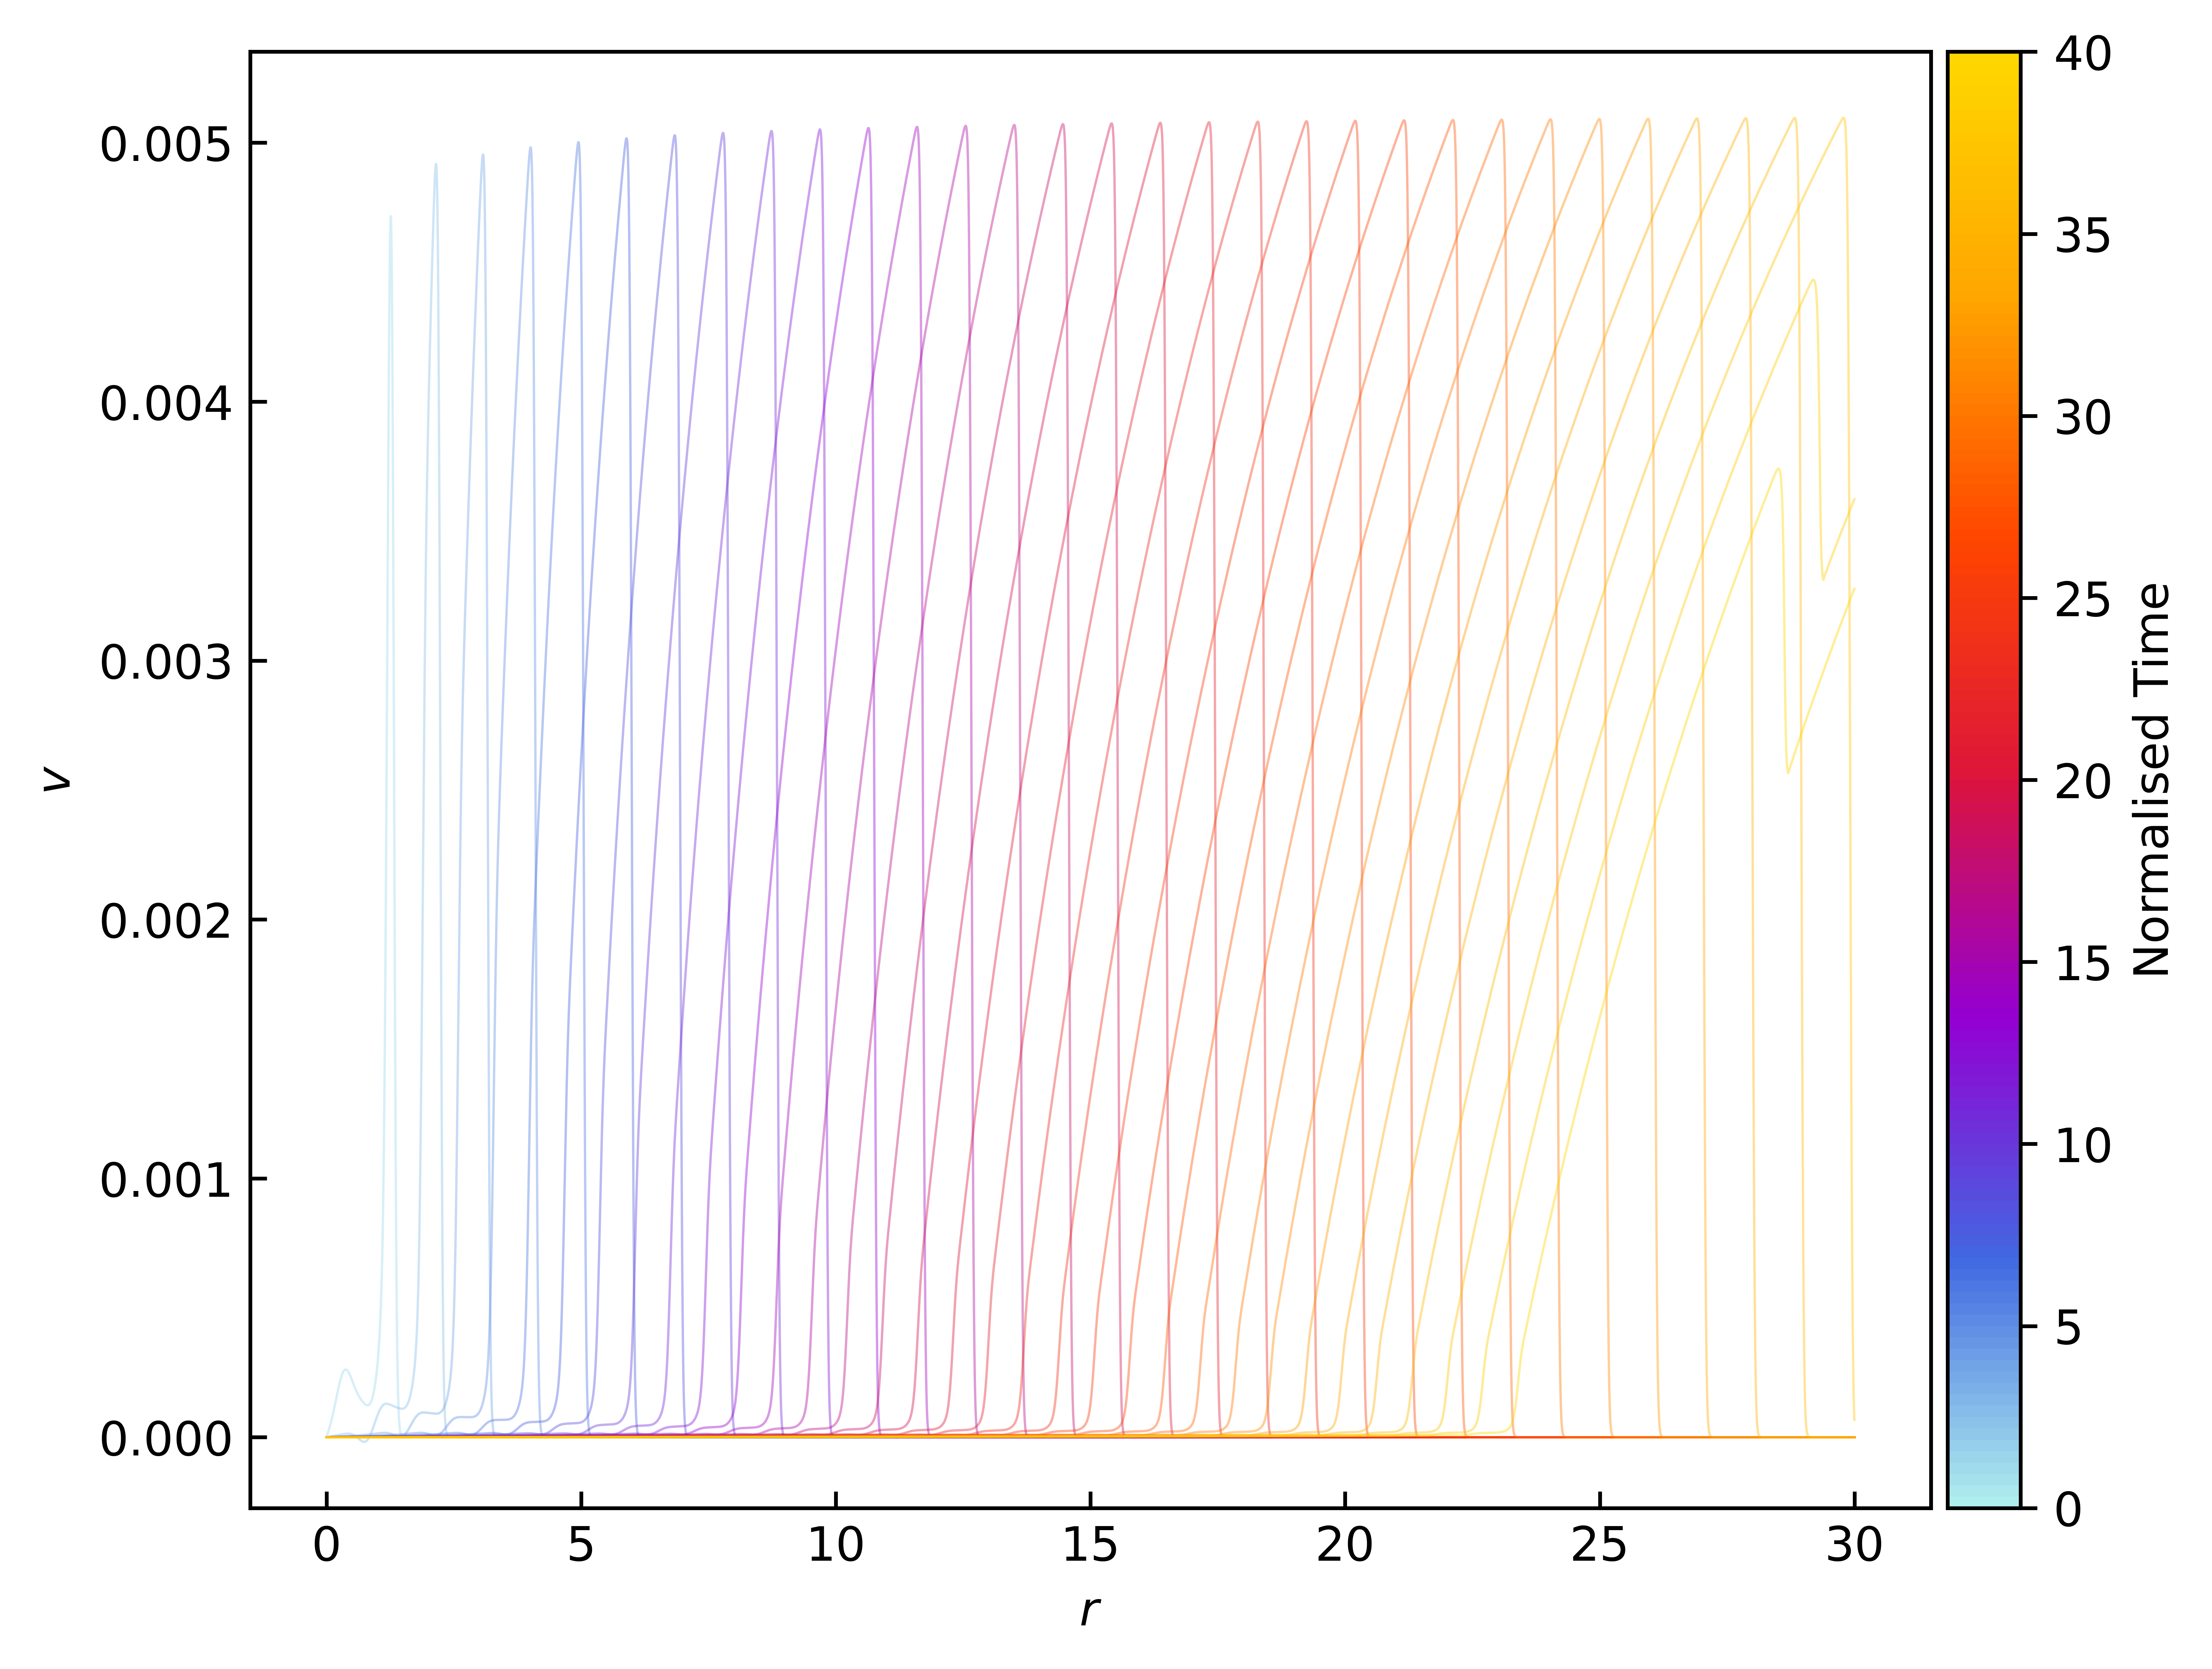

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import numpy as np
import h5py
plt.rcParams.update({'figure.dpi': 1000})
colors = ['paleturquoise','royalblue', 'darkviolet', 'crimson',  'orangered', 'orange', 'gold']
cmap1 = LinearSegmentedColormap.from_list("blue_purple_cmap", colors, N=256)
bounds = [0, 1.5, 6, 12, 19, 22, 33, 40] 
norm = BoundaryNorm(bounds, cmap1.N)
def colouring(t):
    return cmap1(t)

factor = 1.0
end = -1
step = 3
fig, axes = plt.subplots(1,1, constrained_layout=True)
with h5py.File('scalar.h5', 'r') as f:
    r = np.array(f['init/r'])
    snaps = f['snapshots']
    list_snap = list(snaps.keys())
    maxt = snaps[list_snap[-1]].attrs['t']
    for snap in list_snap[0:end:step]:
        group = snaps[snap]
        t = group.attrs['t']
        v = np.array(group['v'])
        colr = colouring(t/maxt)
        r_scaled = r
        axes.plot(r_scaled, v, alpha=0.4, lw=0.5, color=colr)
axes.set_xlabel(r'$\mathit{r}$')
axes.set_ylabel(r'$\mathit{v}$')
axes.tick_params(direction='in', which='both') 
norm = mpl.colors.Normalize(vmin=0, vmax=maxt/factor)
colors = colouring(np.linspace(0, 1/factor, 128))
new_cmap = mpl.colors.ListedColormap(colors)
sm = mpl.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical',pad=0.01, fraction=0.3)
cbar.set_label(r'Normalised Time')
plt.savefig("test.pdf", format="pdf")